In [208]:
from tiffConverter import convert_to_numpy
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [209]:
recon_location = "/Users/levih/Desktop/TomoMono/reconstructions/foamRecon_notNormalized_20240717-143914_gpu.tif"
# recon_location = "/Users/levih/Desktop/TomoMono/reconstructions/foamRecon20240709-152238.tif"
tomo, tomo_scale_info = convert_to_numpy(recon_location)

520 900 900


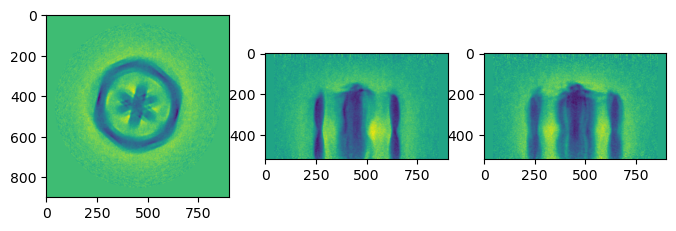

In [210]:
#Volume dimensions
w,h,d = np.shape(tomo)
print(w,h,d)

fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8,8))
axs[0].imshow(tomo[260,:,:])
axs[1].imshow(tomo[:,450,:])
axs[2].imshow(tomo[:,:,450])

In [211]:
ang = tomopy.angles(12, 0, 360)
tomopyProj = tomopy.project(tomo, ang)[0]

In [212]:
#Read in Kevin projection for reference
aligned_proj_location = "/Users/levih/Desktop/TomoMono/alignedProjections/aligned_foamTomo20240716-100346.tif"
kevinProj, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)
kevinProj = kevinProj[0]

#Crop to correct region like tomopy
w, h = kevinProj.shape
res = cv2.matchTemplate(tomopyProj.astype(np.float32),kevinProj.astype(np.float32),cv2.TM_CCOEFF_NORMED)
loc = np.where( res == res.max())
print(loc)
pt = list(zip(*loc[::-1]))[0]
print(pt)
tomopyProj_cropped = tomopyProj[pt[1]:w + pt[1] , pt[0]: h+pt[0] ]

# Crop out zero padded region
tomopyProj_cropped = tomopyProj_cropped[:,100:700]
kevinProj = kevinProj[:,100:700]

(array([0]), array([226]))
(226, 0)


In [213]:
# # Uncomment to match max and min
# # Calculate min and max of proj_scaled and image_proj
# tomopyProj_cropped_min, tomopyProj_cropped_max = tomopyProj_cropped.min(), tomopyProj_cropped.max()
# kevinProj_min, kevinProj_max = kevinProj.min(), kevinProj.max()
# # Scale proj_scaled to match the range of image_proj
# tomopyProj_cropped_normalized = (tomopyProj_cropped - tomopyProj_cropped_min) / (tomopyProj_cropped_max - tomopyProj_cropped_min)  # Normalize proj_scaled to [0, 1]
# tomopyProj_scaled = tomopyProj_cropped_normalized * (kevinProj_max - kevinProj_min) + kevinProj_min  # Scale to [image_proj_min, image_proj_max]

# Uncomment to match 5th and 95th percentile
# Calculate the 5th and 95th percentiles of tomopyProj_cropped and kevinProj
tomopyProj_cropped_p5, tomopyProj_cropped_p95 = np.percentile(tomopyProj_cropped, [5, 95])
kevinProj_p5, kevinProj_p95 = np.percentile(kevinProj, [5, 95])
# Normalize tomopyProj_cropped to [0, 1] based on its 5th and 95th percentiles
tomopyProj_cropped_normalized = (tomopyProj_cropped - tomopyProj_cropped_p5) / (tomopyProj_cropped_p95 - tomopyProj_cropped_p5)
# Scale to [kevinProj_p5, kevinProj_p95]
tomopyProj_scaled = tomopyProj_cropped_normalized * (kevinProj_p95 - kevinProj_p5) + kevinProj_p5

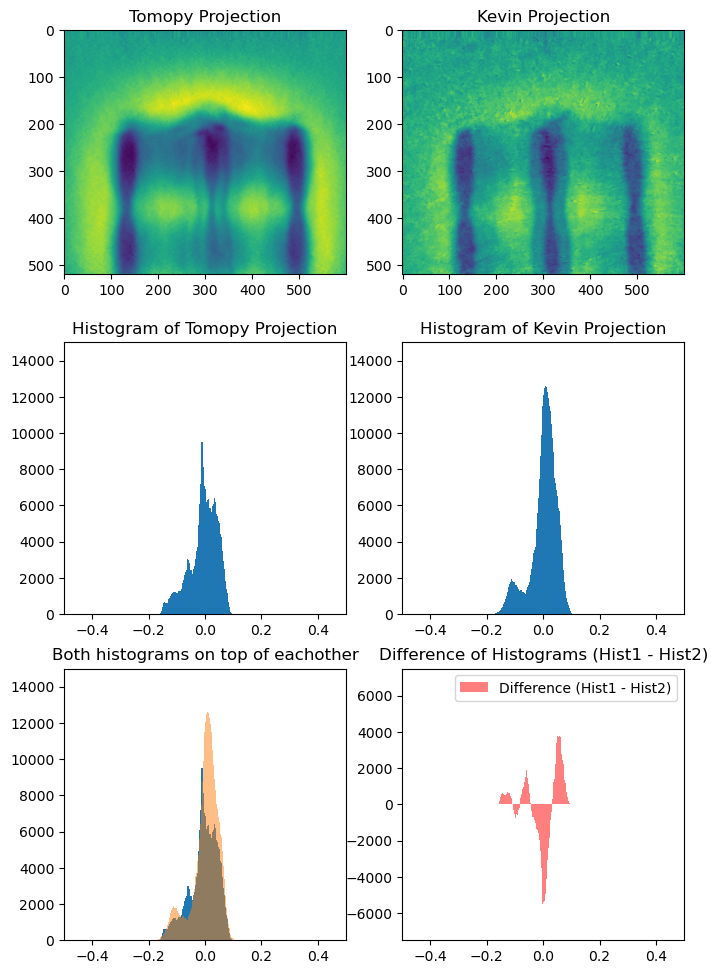

In [214]:
#Plotting
fig1, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
axs[0,0].imshow(tomopyProj_scaled)
axs[0,0].set_title('Tomopy Projection')
axs[1,0].hist(np.ndarray.flatten(tomopyProj_scaled),100)
axs[1,0].set_title('Histogram of Tomopy Projection')
axs[1,0].set_ylim(0,15000)
axs[1,0].set_xlim(-0.5,0.5)

axs[0,1].imshow(kevinProj)
axs[0,1].set_title('Kevin Projection')
axs[1,1].hist(np.ndarray.flatten(kevinProj),100)
axs[1,1].set_title('Histogram of Kevin Projection')
axs[1,1].set_ylim(0,15000)
axs[1,1].set_xlim(-0.5,0.5)

axs[2,0].hist(np.ndarray.flatten(tomopyProj_scaled),100)
axs[2,0].hist(np.ndarray.flatten(kevinProj),100, alpha=0.5)
axs[2,0].set_ylim(0,15000)
axs[2,0].set_xlim(-0.5,0.5)
axs[2,0].set_title('Both histograms on top of eachother')

# Create histograms
bins = 100  # You can adjust the number of bins
hist1, bin_edges1 = np.histogram(tomopyProj_scaled, bins=bins)
hist2, bin_edges2 = np.histogram(kevinProj, bins=bins)

# Subtract the histograms
hist_diff = hist1 - hist2

# Plot the histograms and their difference
bin_centers = (bin_edges1[:-1] + bin_edges1[1:]) / 2
axs[2,1].bar(bin_centers, hist_diff, width=bin_edges1[1] - bin_edges1[0], alpha=0.5, label='Difference (Hist1 - Hist2)', color='red')
axs[2,1].legend()
axs[2,1].set_title('Difference of Histograms (Hist1 - Hist2)')
axs[2,1].set_ylim(-7500,7500)
axs[2,1].set_xlim(-0.5,0.5)

plt.show()